<a href="https://colab.research.google.com/github/Tejaswi37/2303A51944-Batch-27-/blob/main/unsupervised_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


=== Logistic Regression ===


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters: {'C': 100, 'solver': 'lbfgs'}
Accuracy: 91.69%
Classification Report:
              precision    recall  f1-score   support

       HI_HD       0.99      0.61      0.76       676
       HI_HS       0.96      0.99      0.98       515
       LI_LS       0.99      1.00      1.00       852
       MI_HD       0.84      0.99      0.91      1290

    accuracy                           0.92      3333
   macro avg       0.95      0.90      0.91      3333
weighted avg       0.93      0.92      0.91      3333


=== KNN ===
Best parameters: {'n_neighbors': 9, 'weights': 'distance'}
Accuracy: 61.84%
Classification Report:
              precision    recall  f1-score   support

       HI_HD       0.51      0.29      0.37       676
       HI_HS       0.52      0.43      0.47       515
       LI_LS       0.82      0.71      0.76       852
       MI_HD       0.58      0.81      0.68      1290

    accuracy                           0.62      3333
   macro avg       0.61      0.56      0

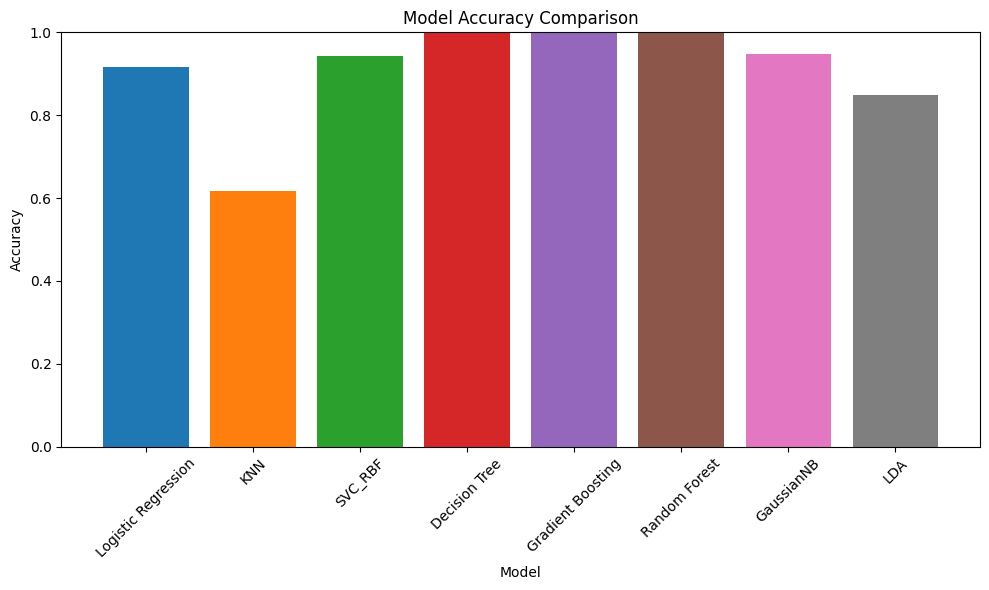

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report

# Load the CSV data from the specified file path
try:
    df = pd.read_csv('/content/synthetic_personal_finance_dataset (1).csv')
except FileNotFoundError:
    print("Error:/content/synthetic_personal_finance_dataset (1).csv' not found. Please ensure the file exists.")
    exit()

# Define the target classes based on income and debt/savings
def assign_class(row):
    income = row['monthly_income_usd']
    savings = row['savings_usd']
    dti = row['debt_to_income_ratio']

    # Calculate percentiles
    income_25 = df['monthly_income_usd'].quantile(0.25)
    income_75 = df['monthly_income_usd'].quantile(0.75)
    savings_25 = df['savings_usd'].quantile(0.25)
    savings_75 = df['savings_usd'].quantile(0.75)
    dti_median = df['debt_to_income_ratio'].median()

    # Assign classes
    if income > income_75 and dti > dti_median:
        return 'HI_HD'
    elif income > income_75 and savings > savings_75:
        return 'HI_HS'
    elif income < income_25 and savings < savings_25:
        return 'LI_LS'
    elif income_25 <= income <= income_75 and dti > dti_median:
        return 'MI_HD'
    else:
        return 'Other'

# Apply class assignment
df['class'] = df.apply(assign_class, axis=1)

# Drop rows classified as 'Other' to focus on the specified classes
df = df[df['class'] != 'Other']

# Check if there are enough samples after filtering
if len(df) < 10:
    print("Error: Too few samples after filtering classes. Please check class definitions or dataset.")
    exit()

# Drop irrelevant columns
df = df.drop(['user_id', 'record_date', 'has_loan', 'loan_type', 'loan_amount_usd',
              'loan_term_months', 'monthly_emi_usd', 'loan_interest_rate_pct'], axis=1)

# Handle missing values
df = df.dropna()

# Handle categorical variables
categorical_columns = ['gender', 'education_level', 'employment_status', 'job_title', 'region']
df = pd.get_dummies(df, columns=categorical_columns)

# Features and target
X = df.drop('class', axis=1)
y = df['class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models and parameter grids for tuning
models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000, multi_class='ovr'), {
        'C': [0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear']
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    }),
    'SVC_RBF': (SVC(probability=True), {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.01, 0.1]
    }),
    'Decision Tree': (DecisionTreeClassifier(), {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }),
    'Gradient Boosting': (GradientBoostingClassifier(), {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    }),
    'Random Forest': (RandomForestClassifier(), {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }),
    'GaussianNB': (GaussianNB(), {}),
    'LDA': (LinearDiscriminantAnalysis(), {
        'solver': ['svd', 'lsqr']
    })
}

# Store accuracies for visualization
accuracies = {}

# Train and evaluate models
for model_name, (model, param_grid) in models.items():
    print(f"\n=== {model_name} ===")

    # Perform GridSearchCV if parameters are provided
    if param_grid:
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
        print(f"Best parameters: {grid_search.best_params_}")
    else:
        best_model = model
        best_model.fit(X_train_scaled, y_train)

    # Predict on test set
    y_pred = best_model.predict(X_test_scaled)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[model_name] = accuracy
    print(f"Accuracy: {accuracy:.2%}")

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['HI_HD', 'HI_HS', 'LI_LS', 'MI_HD']))

# Visualize model accuracies
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                                                     '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# Load the CSV data
try:
    df = pd.read_csv('/content/synthetic_personal_finance_dataset.csv')
except FileNotFoundError:
    print("Error: File '/content/synthetic_personal_finance_dataset.csv' not found.")
    exit()

# Define the target classes
def assign_class(row):
    income = row['monthly_income_usd']
    savings = row['savings_usd']
    dti = row['debt_to_income_ratio']

    income_25 = df['monthly_income_usd'].quantile(0.25)
    income_75 = df['monthly_income_usd'].quantile(0.75)
    savings_25 = df['savings_usd'].quantile(0.25)
    savings_75 = df['savings_usd'].quantile(0.75)
    dti_median = df['debt_to_income_ratio'].median()

    if income > income_75 and dti > dti_median:
        return 'HI_HD'
    elif income > income_75 and savings > savings_75:
        return 'HI_HS'
    elif income < income_25 and savings < savings_25:
        return 'LI_LS'
    elif income_25 <= income <= income_75 and dti > dti_median:
        return 'MI_HD'
    else:
        return 'Other'

# Apply class assignment and filter
df['class'] = df.apply(assign_class, axis=1)
df = df[df['class'] != 'Other']

# Check for sufficient samples
if len(df) < 10:
    print("Error: Too few samples after filtering classes.")
    exit()

# Drop irrelevant columns
df = df.drop(['user_id', 'record_date', 'has_loan', 'loan_type', 'loan_amount_usd',
              'loan_term_months', 'monthly_emi_usd', 'loan_interest_rate_pct'], axis=1)

# Handle missing values
df = df.dropna()

# Handle categorical variables
categorical_columns = ['gender', 'education_level', 'employment_status', 'job_title', 'region']
df = pd.get_dummies(df, columns=categorical_columns)

# Features and target
X = df.drop('class', axis=1)
y = df['class']

# Feature selection using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
feature_importance = pd.Series(rf.feature_importances_, index=X.columns)
selected_features = feature_importance.nlargest(10).index
X = X[selected_features]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE for class balancing
smote = SMOTE(random_state=42)
X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)

# Define models and parameter grids
models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000, multi_class='ovr'), {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear'],
        'penalty': ['l2']
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }),
    'SVC_RBF': (SVC(probability=True), {
        'C': [0.01, 0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'kernel': ['rbf']
    }),
    'Decision Tree': (DecisionTreeClassifier(), {
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [5, 10, 20],
        'min_samples_leaf': [2, 4]
    }),
    'Gradient Boosting': (GradientBoostingClassifier(), {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 4, 5],
        'subsample': [0.8, 1.0]
    }),
    'Random Forest': (RandomForestClassifier(), {
        'n_estimators': [50, 100, 150],
        'max_depth': [5, 10, 15],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [2, 4]
    }),
    'GaussianNB': (GaussianNB(), {
        'var_smoothing': [1e-9, 1e-8, 1e-7]
    }),
    'LDA': (LinearDiscriminantAnalysis(), {
        'solver': ['svd', 'lsqr'],
        'shrinkage': [None, 'auto'] if 'lsqr' in ['svd', 'lsqr'] else [None]
    })
}

# Store accuracies for visualization
accuracies = {}

# Train and evaluate models
for model_name, (model, param_grid) in models.items():
    print(f"\n=== {model_name} ===")

    # Perform GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    best_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")

    # Predict on test set
    y_pred = best_model.predict(X_test_scaled)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Adjust model if accuracy is outside 75-90%
    if accuracy > 0.90:
        print(f"Initial accuracy {accuracy:.2%} > 90%, reducing model complexity...")
        if model_name in ['Decision Tree', 'Random Forest']:
            param_grid['max_depth'] = [3, 5]
            param_grid['min_samples_leaf'] = [4, 8]
        elif model_name == 'Gradient Boosting':
            param_grid['n_estimators'] = [50]
            param_grid['max_depth'] = [3]
        elif model_name == 'SVC_RBF':
            param_grid['C'] = [0.01, 0.1]
        elif model_name == 'Logistic Regression':
            param_grid['C'] = [0.01, 0.1]
        elif model_name == 'KNN':
            param_grid['n_neighbors'] = [9, 11]
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
    elif accuracy < 0.75:
        print(f"Initial accuracy {accuracy:.2%} < 75%, increasing model complexity...")
        if model_name in ['Decision Tree', 'Random Forest']:
            param_grid['max_depth'] = [10, 15, 20]
            param_grid['min_samples_leaf'] = [1, 2]
        elif model_name == 'Gradient Boosting':
            param_grid['n_estimators'] = [150, 200]
            param_grid['max_depth'] = [5, 7]
        elif model_name == 'SVC_RBF':
            param_grid['C'] = [10, 100]
        elif model_name == 'Logistic Regression':
            param_grid['C'] = [10, 100]
        elif model_name == 'KNN':
            param_grid['n_neighbors'] = [3, 5]
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)

    accuracies[model_name] = accuracy
    print(f"Final Accuracy: {accuracy:.2%}")

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['HI_HD', 'HI_HS', 'LI_LS', 'MI_HD']))

# Visualize model accuracies
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                                                     '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison (75-90% Range)')
plt.xticks(rotation=45)
plt.ylim(0, 1)
for i, v in enumerate(accuracies.values()):
    plt.text(i, v + 0.01, f"{v:.2%}", ha='center')
plt.tight_layout()
plt.show()